In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

C:\Users\82103\AppData\Local\Temp\ipykernel_46892\898554682.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# CSV 파일 읽기
file_path = "Project_data.csv"
data = pd.read_csv(file_path, index_col=0)

In [3]:
data.head()

,V1,V2
1,1.552925,0.952583
2,0.683919,2.338332
3,0.908432,0.822729
4,1.619464,0.240459
5,1.802534,2.183461


In [4]:
#Label 할당
data['label'] = np.nan
data = np.array(data)
data[0:60,2] = 0
data[60:120,2] = 1
data[120:180,2] = 2
data[180:,2] = 3

In [16]:
##클러스터 수 정하기
K = 3
# k-means 클러스터링
kmeans = KMeans(n_clusters=K, random_state=42)
kmeans_labels = kmeans.fit_predict(data[:,:2])

# GMM 클러스터링
gmm = GaussianMixture(n_components=K, random_state=42)
gmm_labels = gmm.fit_predict(data[:,:2])

# 중심점 get
km_mu = kmeans.cluster_centers_
gmm_mu = gmm.means_

In [17]:
# When K = 5
if K == 5:
  # alpha = 1, sigma_y = 0.5
  DPMM_mu = np.array([[-2.347 ,-2.507],
                      [1.419, 1.416],
                      [-0.989, -0.974],
                      [-1.467, 1.458],
                      [1.424, -1.468]])
  DPMM_sigma = np.array([[[0.896, 0.144],
                          [0.144, 0.900]],
                          [[0.416, -0.006],
                           [-0.006, 0.386]],
                           [[0.488, 0.097],
                            [0.097 ,0.670]],
                            [[0.258, 0.022],
                             [0.022, 0.26]],
                             [[0.617, -0.093],
                              [-0.093, 0.363]]
                              ])
if K == 4:
  # alpha = 1, sigma_y = 1
  DPMM_mu = np.array([[1.415, 1.412],
                      [-1.805, -1.931],
                      [1.289, -1.446],
                      [-1.337, 1.131]])
  DPMM_sigma = np.array([[[0.314, 0.011],
                          [0.011, 0.285]],
                          [[0.626, 0.399],
                           [0.399, 0.713]],
                          [[0.689, -0.098],
                           [-0.098 ,0.253]],
                          [[0.222, -0.146],
                           [-0.146, 0.598]]
                           ])
if K == 3:
  # alpha = 0.01, sigma_y = 1.5
  DPMM_mu = np.array([[-0.195,1.054],
                      [-2.005,-2.222],
                      [1.426, -1.458]])
  DPMM_sigma = np.array([[[2.019, 0.229],
                          [0.229, 0.888]],
                         [[0.806, 0.243],
                          [0.243, 0.754]],
                         [[0.667, -0.018],
                          [-0.018, 0.415]]
                          ])

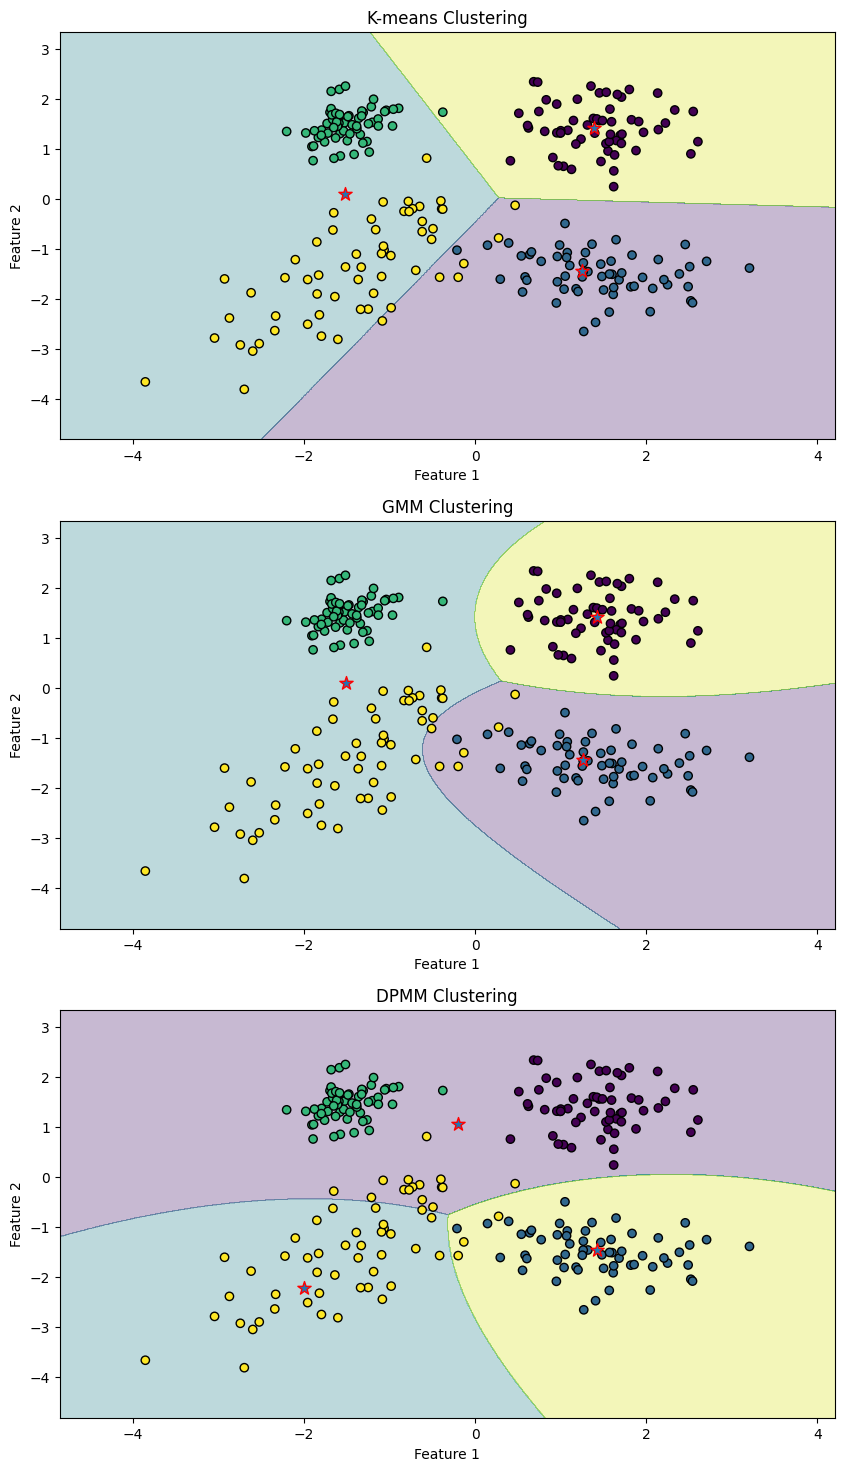

In [18]:
h = .005  # step size in the mesh
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# K-means decision boundary
Z_kmeans = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z_kmeans = Z_kmeans.reshape(xx.shape)

# GMM decision boundary
Z_gmm = gmm.predict(np.c_[xx.ravel(), yy.ravel()])
Z_gmm = Z_gmm.reshape(xx.shape)



plt.figure(figsize=(10, 18))

plt.subplot(3,1,1)

plt.contourf(xx, yy, Z_kmeans, alpha=0.3, cmap='viridis')
plt.scatter(data[:, 0], data[:, 1], c = data[:,2], cmap='viridis', edgecolor='k')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.scatter(km_mu[:,0], gmm_mu[:,1], marker='*', edgecolors="red", s=100)

plt.subplot(3,1,2)

plt.contourf(xx, yy, Z_gmm, alpha=0.3, cmap='viridis')
plt.scatter(data[:, 0], data[:, 1], c = data[:,2],cmap='viridis', edgecolor='k')
plt.title('GMM Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.scatter(gmm_mu[:,0], gmm_mu[:,1], marker='*', edgecolors="red", s=100)


#### DPMM part
dgmm = GaussianMixture(n_components=5, covariance_type='full')
dgmm.means_ = DPMM_mu
dgmm.covariances_ = DPMM_sigma
dgmm.weights_ = np.ones(DPMM_mu.shape[0]) / DPMM_mu.shape[0]
dgmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(DPMM_sigma))

h = .01  # 그리드의 스텝 사이즈
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = dgmm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.subplot(3,1,3)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.scatter(data[:, 0], data[:, 1], c = data[:,2], cmap='viridis', edgecolor='k')
plt.title('DPMM Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.scatter(DPMM_mu[:,0], DPMM_mu[:,1], marker='*', edgecolors="red", s=100)